In [1]:
from patchify import patchify
from transformers import SamModel, SamProcessor, SamConfig
import torch
from datasets import Dataset
from PIL import Image
from matplotlib.patches import Rectangle
import matplotlib.pyplot as plt
import random
import time

from utils import *

c:\Users\firdavs\Documents\ARCL\DINOv2_Sparse_Matching\.venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
c:\Users\firdavs\Documents\ARCL\DINOv2_Sparse_Matching\.venv\lib\site-packages\mobile_sam\modeling\tiny_vit_sam.py:656: UserWarning: Overwriting tiny_vit_5m_224 in registry with mobile_sam.modeling.tiny_vit_sam.tiny_vit_5m_224. This is because the name being registered conflicts with an existing name. Please check if this is not expected.
  return register_model(fn_wrapper)
c:\Users\firdavs\Documents\ARCL\DINOv2_Sparse_Matching\.venv\lib\site-packages\mobile_sam\modeling\tiny_vit_sam.py:656: UserWarning: Overwriting tiny_vit_11m_224 in registry with mobile_sam.modeling.tiny_vit_sam.tiny_vit_11m_224. This is because the name being registered conflicts with an existing name. Please check if this is not expect

In [2]:
paths = {
    'train': {'images':   r"data/sam_finetuning/train/images/",
              'masks':    r"data/sam_finetuning/train/masks/",
              'bboxes':   r"data/sam_finetuning/train/bboxes/"},
    'val':   {'images':   r"data/sam_finetuning/val/images/",
              'masks':    r"data/sam_finetuning/val/masks/",
              'bboxes':   r"data/sam_finetuning/val/bboxes/"},
    'test':  {'images':   r"data/sam_finetuning/test/images/",
              'masks':    r"data/sam_finetuning/test/masks/",
              'bboxes':   r"data/sam_finetuning/test/bboxes/"}
}

train_images = get_images(paths['train']['images'])
val_images   = get_images(paths['val']['images'])
test_images  = get_images(paths['test']['images'])

train_masks  = get_images(paths['train']['masks'])
val_masks    = get_images(paths['val']['masks'])
test_masks   = get_images(paths['test']['masks'])

train_bboxes = get_bboxes(paths['train']['bboxes'])
val_bboxes   = get_bboxes(paths['val']['bboxes'])
test_bboxes  = get_bboxes(paths['test']['bboxes'])

n_train = len(train_images)
n_val   = len(val_images)
n_test  = len(test_images)

print(f'num train_images: {n_train}')
print(f'num val_images: {n_val}')
print(f'num test_images: {n_test}')

original_dims = (512, 641)

num train_images: 411
num val_images: 102
num test_images: 101


In [3]:
def resize_image(img_arr: np.ndarray, w: int, h: int) -> np.ndarray:
    img = Image.fromarray(img_arr)
    img = img.resize((w, h))
    return np.array(img)

def prepare_datasets(patch_size: int, image_dims: tuple[int, int]) -> tuple[Dataset, Dataset]:
    step = patch_size

    x_factor = original_dims[1] / image_dims[1]
    y_factor = original_dims[0] / image_dims[0]

    # Combine train and val images as train
    train_img_patches = []
    train_mask_patches = []
    
    # val_img_patches = []
    # val_mask_patches = []

    test_img_patches = []
    test_mask_patches = []

    # Process train images
    i = 0
    for key in tqdm(train_images):
        # Load and resize image
        img = train_images[key]
        img = resize_image(img, image_dims[0], image_dims[1])

        # Patchify image
        patches_img = patchify(img, (patch_size, patch_size, 3), step=step)
        for j in range(patches_img.shape[0]):
            for k in range(patches_img.shape[1]):
                single_patch_img = patches_img[j,k,:,:][0]
                train_img_patches.append(single_patch_img)
        
        # Load and resize mask
        mask = train_masks[key][:, :, 0] / 255
        mask = np.array(mask, dtype=np.uint8)
        mask = resize_image(mask, image_dims[0], image_dims[1])

        # Patchify mask
        patches_mask = patchify(mask, (patch_size, patch_size), step=step)
        for j in range(patches_mask.shape[0]):
            for k in range(patches_mask.shape[1]):
                single_patch_mask = patches_mask[j,k,:,:]
                train_mask_patches.append(single_patch_mask)
        
        i += 1

    # Process val images
    # i = 0
    for key in tqdm(val_images):
        # Load and resize image
        img = val_images[key]
        img = resize_image(img, image_dims[0], image_dims[1])

        # Patchify image
        patches_img = patchify(img, (patch_size, patch_size, 3), step=step)
        for j in range(patches_img.shape[0]):
            for k in range(patches_img.shape[1]):
                single_patch_img = patches_img[j,k,:,:][0]
                # val_img_patches.append(single_patch_img)
                train_img_patches.append(single_patch_img)

        # Load and resize mask
        mask = val_masks[key][:, :, 0] / 255
        mask = np.array(mask, dtype=np.uint8)
        mask = resize_image(mask, image_dims[0], image_dims[1])

        # Patchify mask
        patches_mask = patchify(mask, (patch_size, patch_size), step=step)
        for j in range(patches_mask.shape[0]):
            for k in range(patches_mask.shape[1]):
                single_patch_mask = patches_mask[j,k,:,:]
                # val_mask_patches.append(single_patch_mask)
                train_mask_patches.append(single_patch_mask)
        
        i += 1

    # Process test images
    i = 0
    for key in tqdm(test_images):
        # Load and resize image
        img = test_images[key]
        img = resize_image(img, image_dims[0], image_dims[1])

        # Patchify image
        patches_img = patchify(img, (patch_size, patch_size, 3), step=step)
        for j in range(patches_img.shape[0]):
            for k in range(patches_img.shape[1]):
                single_patch_img = patches_img[j,k,:,:][0]
                test_img_patches.append(single_patch_img)

        # Load and resize mask
        mask = test_masks[key][:, :, 0] / 255
        mask = np.array(mask, dtype=np.uint8)
        mask = resize_image(mask, image_dims[0], image_dims[1])

        # Patchify mask
        patches_mask = patchify(mask, (patch_size, patch_size), step=step)
        for j in range(patches_mask.shape[0]):
            for k in range(patches_mask.shape[1]):
                single_patch_mask = patches_mask[j,k,:,:]
                test_mask_patches.append(single_patch_mask)
        
        i += 1 
        
    X_train = np.array(train_img_patches)
    Y_train = np.array(train_mask_patches)
    
    # X_val = np.array(val_img_patches)
    # Y_val = np.array(val_mask_patches)

    X_test = np.array(test_img_patches)
    Y_test = np.array(test_mask_patches)

    # Have balanced classes
    valid_indices = [i for i, mask in enumerate(Y_train) if mask.max() != 0]
    X_train = X_train[valid_indices]
    Y_train = Y_train[valid_indices]
    print("X_train shape:", X_train.shape)
    print("Y_train shape:", Y_train.shape)
    
    # valid_indices = [i for i, mask in enumerate(Y_val) if mask.max() != 0]
    # X_val = X_val[valid_indices]
    # Y_val = Y_val[valid_indices]
    # print("X_val shape:", X_val.shape)
    # print("Y_val shape:", Y_val.shape)
    
    valid_indices = [i for i, mask in enumerate(Y_test) if mask.max() != 0]
    X_test = X_test[valid_indices]
    Y_test = Y_test[valid_indices]
    print("X_test shape:", X_test.shape)
    print("Y_test shape:", Y_test.shape)
    
    train_dict = {
        "image": [Image.fromarray(img.astype('uint8')) for img in X_train],
        "mask":  [Image.fromarray(mask) for mask in Y_train],
    }
    # val_dict = {
    #     "image": [Image.fromarray(img.astype('uint8')) for img in X_val],
    #     "mask":  [Image.fromarray(mask) for mask in Y_val],
    # }
    test_dict = {
        "image": [Image.fromarray(img.astype('uint8')) for img in X_test],
        "mask":  [Image.fromarray(mask) for mask in Y_test],
    }

    train_dataset = Dataset.from_dict(train_dict)
    # val_dataset  = Dataset.from_dict(val_dict)
    test_dataset  = Dataset.from_dict(test_dict)
    
    return train_dataset, test_dataset

In [4]:
# Get bounding boxes from mask. (FROM ONLINE SOURCE)
def get_bounding_box(ground_truth_map: np.ndarray) -> list[int]:
    # get bounding box from mask
    y_indices, x_indices = np.where(ground_truth_map > 0)
    x_min, x_max = np.min(x_indices), np.max(x_indices)
    y_min, y_max = np.min(y_indices), np.max(y_indices)
    # add perturbation to bounding box coordinates
    H, W = ground_truth_map.shape
    x_min = max(0, x_min - np.random.randint(0, 20))
    x_max = min(W, x_max + np.random.randint(0, 20))
    y_min = max(0, y_min - np.random.randint(0, 20))
    y_max = min(H, y_max + np.random.randint(0, 20))
    bbox = [x_min, y_min, x_max, y_max]

    return bbox

In [5]:
patch_size = 256
image_size = 512

train_dataset, test_dataset = prepare_datasets(patch_size, (image_size, image_size))

100%|██████████| 101/101 [00:00<00:00, 238.52it/s]


X_train shape: (525, 256, 256, 3)
Y_train shape: (525, 256, 256)
X_test shape: (108, 256, 256, 3)
Y_test shape: (108, 256, 256)


In [6]:
train_dataset, test_dataset

(Dataset({
     features: ['image', 'mask'],
     num_rows: 525
 }),
 Dataset({
     features: ['image', 'mask'],
     num_rows: 108
 }))

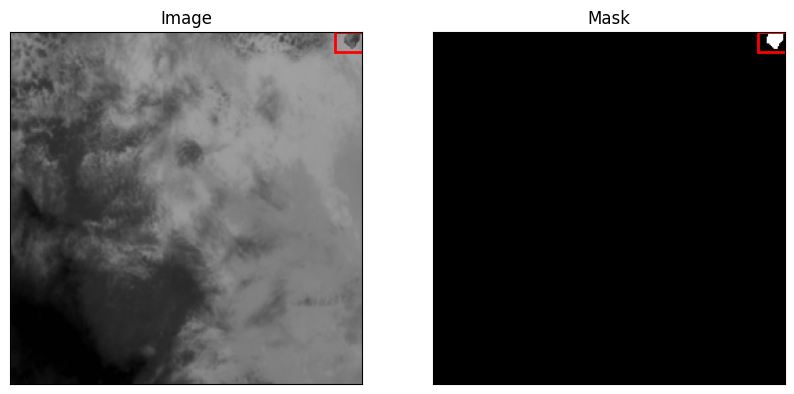

In [7]:
img_num = random.randint(0, n_train+n_val-1)
example_image = train_dataset[img_num]["image"]
example_mask = np.array(train_dataset[img_num]["mask"]) * 255
# example_bbox = train_dataset[img_num]["bbox"]

bbox = get_bounding_box(np.array(example_mask))

fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# Plot the iamge on left
axes[0].imshow(np.array(example_image), cmap='gray')
axes[0].set_title("Image")

# Plot the mask on right
axes[1].imshow(example_mask, cmap='gray')
axes[1].set_title("Mask")

# Hide axis ticks and labels
for ax in axes:
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    
    rect_pred = Rectangle((bbox[0], bbox[1]), bbox[2] - bbox[0], bbox[3] - bbox[1], linewidth=2, edgecolor='r', facecolor='none')
    # rect_true = Rectangle((example_bbox[0], example_bbox[1]), example_bbox[2], example_bbox[3], linewidth=2, edgecolor='g', facecolor='none')
    
    ax.add_patch(rect_pred)
    # ax.add_patch(rect_true)

plt.show()

In [8]:
from torch.utils.data import Dataset

class SAMDataset(Dataset):
    """
    Used to create a dataset that serves input images and masks.
    It takes a dataset and a processor as input and overrides the __len__ and __getitem__ methods of the Dataset class.
    """
    def __init__(self, dataset, processor):
        self.dataset = dataset
        self.processor = processor

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        item = self.dataset[idx]
        image = item["image"]
        
        ground_truth_mask = np.array(item["mask"])

        # Get bounding box prompt
        # prompt = get_bounding_box(ground_truth_mask)
        prompt = [0, 0, 256, 256]

        # Prepare image and prompt for the model
        inputs = self.processor(image, input_boxes=[[prompt]], return_tensors="pt")

        # Remove batch dimension which the processor adds by default
        inputs = {k:v.squeeze(0) for k,v in inputs.items()}

        # Add ground truth segmentation
        inputs["ground_truth_mask"] = ground_truth_mask

        return inputs

In [9]:
def get_device() -> torch.device:
    if torch.cuda.is_available():
        device = torch.device("cuda")
    else:
        device = torch.device("cpu")
    return device

In [10]:
device = get_device()
torch.cuda.empty_cache()

from transformers import SamModel, SamConfig, SamProcessor
processor = SamProcessor.from_pretrained("facebook/sam-vit-base")
model = SamModel.from_pretrained("facebook/sam-vit-base")

In [11]:
train_sam_dataset = SAMDataset(dataset=train_dataset, processor=processor)

In [12]:
example = train_sam_dataset[0]
for k,v in example.items():
  print(k,v.shape)

pixel_values torch.Size([3, 1024, 1024])
original_sizes torch.Size([2])
reshaped_input_sizes torch.Size([2])
input_boxes torch.Size([1, 4])
ground_truth_mask (256, 256)


In [13]:
from torch.utils.data import DataLoader
train_dataloader = DataLoader(train_sam_dataset, batch_size=2, shuffle=True, drop_last=False)

In [14]:
batch = next(iter(train_dataloader))
for k,v in batch.items():
    print(k,v.shape)

pixel_values torch.Size([2, 3, 1024, 1024])
original_sizes torch.Size([2, 2])
reshaped_input_sizes torch.Size([2, 2])
input_boxes torch.Size([2, 1, 4])
ground_truth_mask torch.Size([2, 256, 256])


In [15]:
batch["ground_truth_mask"].shape

torch.Size([2, 256, 256])

In [16]:
from torch.optim import Adam
import monai

# make sure we only compute gradients for mask decoder
for name, param in model.named_parameters():
    if name.startswith("vision_encoder") or name.startswith("prompt_encoder") or name.startswith("image_encoder"):
        param.requires_grad_(False)

# Initialize the optimizer and the loss function
optimizer = Adam(model.mask_decoder.parameters(), lr=1e-5, weight_decay=0)
seg_loss = monai.losses.DiceCELoss(sigmoid=True, squared_pred=True, reduction='mean')

In [17]:
from tqdm import tqdm
from statistics import mean
import torch
from torch.nn.functional import threshold, normalize

# Training loop
num_epochs = 25

device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

model.train()
for epoch in range(num_epochs):
    epoch_losses = []
    for batch in tqdm(train_dataloader):
        # forward pass
        outputs = model(pixel_values=batch["pixel_values"].to(device),
                        input_boxes=batch["input_boxes"].to(device),
                        multimask_output=False)

        # compute loss
        predicted_masks = outputs.pred_masks.squeeze(1)
        ground_truth_masks = batch["ground_truth_mask"].float().to(device)
        loss = seg_loss(predicted_masks, ground_truth_masks.unsqueeze(1))

        # backward pass (compute gradients of parameters w.r.t. loss)
        optimizer.zero_grad()
        loss.backward()

        # optimize
        optimizer.step()
        epoch_losses.append(loss.item())

    print(f'EPOCH: {epoch + 1}')
    print(f'\tMean loss: {mean(epoch_losses)}')

100%|██████████| 263/263 [01:12<00:00,  3.63it/s]


EPOCH: 1
	Mean loss: 0.4111546548579186


100%|██████████| 263/263 [01:11<00:00,  3.69it/s]


EPOCH: 2
	Mean loss: 0.10640856297155524


100%|██████████| 263/263 [01:15<00:00,  3.47it/s]


EPOCH: 3
	Mean loss: 0.08815945714655485


100%|██████████| 263/263 [01:15<00:00,  3.50it/s]


EPOCH: 4
	Mean loss: 0.07802486995468802


100%|██████████| 263/263 [01:11<00:00,  3.68it/s]


EPOCH: 5
	Mean loss: 0.07344596976053125


100%|██████████| 263/263 [01:13<00:00,  3.56it/s]


EPOCH: 6
	Mean loss: 0.06671390715391577


100%|██████████| 263/263 [01:13<00:00,  3.58it/s]


EPOCH: 7
	Mean loss: 0.060204697372710524


100%|██████████| 263/263 [01:13<00:00,  3.59it/s]


EPOCH: 8
	Mean loss: 0.0573413221098256


100%|██████████| 263/263 [01:14<00:00,  3.55it/s]


EPOCH: 9
	Mean loss: 0.05645936703266923


100%|██████████| 263/263 [01:12<00:00,  3.63it/s]


EPOCH: 10
	Mean loss: 0.055893734763217066


100%|██████████| 263/263 [01:10<00:00,  3.73it/s]


EPOCH: 11
	Mean loss: 0.051789295873799476


100%|██████████| 263/263 [01:11<00:00,  3.66it/s]


EPOCH: 12
	Mean loss: 0.05010352632696581


100%|██████████| 263/263 [01:11<00:00,  3.66it/s]


EPOCH: 13
	Mean loss: 0.04773221778446107


100%|██████████| 263/263 [01:12<00:00,  3.64it/s]


EPOCH: 14
	Mean loss: 0.04649758456671476


100%|██████████| 263/263 [01:13<00:00,  3.59it/s]


EPOCH: 15
	Mean loss: 0.04704332805483004


100%|██████████| 263/263 [01:11<00:00,  3.69it/s]


EPOCH: 16
	Mean loss: 0.04654571037038367


100%|██████████| 263/263 [01:12<00:00,  3.63it/s]


EPOCH: 17
	Mean loss: 0.04330312722883127


100%|██████████| 263/263 [01:13<00:00,  3.60it/s]


EPOCH: 18
	Mean loss: 0.04208499799613547


100%|██████████| 263/263 [01:13<00:00,  3.60it/s]


EPOCH: 19
	Mean loss: 0.045608142167754724


100%|██████████| 263/263 [01:13<00:00,  3.56it/s]


EPOCH: 20
	Mean loss: 0.04046883543478785


100%|██████████| 263/263 [01:12<00:00,  3.65it/s]


EPOCH: 21
	Mean loss: 0.03822536753780942


100%|██████████| 263/263 [01:12<00:00,  3.64it/s]


EPOCH: 22
	Mean loss: 0.037863717395847686


100%|██████████| 263/263 [01:12<00:00,  3.64it/s]


EPOCH: 23
	Mean loss: 0.0410076733058878


100%|██████████| 263/263 [01:12<00:00,  3.63it/s]


EPOCH: 24
	Mean loss: 0.0365442608902762


100%|██████████| 263/263 [01:12<00:00,  3.64it/s]

EPOCH: 25
	Mean loss: 0.035020528834830165


In [18]:
torch.save(model.state_dict(), f"sam_checkpoints_finetuned/{image_size}_2.pth")

In [19]:
torch.cuda.empty_cache()